# Кафе

Перед открытием нового кафе в Москве необходимо подготовить исследование рынка, чтобы оценить вероятность успеха и определиться с форматом заведения.

В нашем распоряжении имееются открытые данные о заведениях общественного питания в Москве:

Таблица **rest_data**:
- `id` — идентификатор объекта
- `object_name` — название объекта общественного питания
- `chain` — сетевой ресторан
- `object_type` — тип объекта общественного питания
- `address` — адрес
- `number` — количество посадочных мест

**План работы:** <a id="plan"></a> 

1. [Обзор данных](#st1)
2. [Предобработка данных. Приведение типов. Обработка пропущенных значений](#st2)
3. [Исследовательский анализ данных](#st3)
4. [Общий вывод](#st4)
5. [Презентация](#st5)

### [1. Обзор данных](#plan) <a id="st1"></a> 

In [29]:
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy import stats as st
import string
import requests
import re
%matplotlib inline
pd.set_option('display.max_columns', 500)
pd.options.mode.chained_assignment = None

In [5]:
df = pd.read_csv('08_rest_data.csv')

display(df.sample(10))
display(df.info())
display(df['number'].describe())
print('Дубликатов:', df.duplicated().sum())
display(df['chain'].unique())
display(df['object_type'].unique())

,id,object_name,chain,object_type,address,number
2258,153605,Ресторан «Sun and Moon»,нет,ресторан,"город Москва, Большая Никитская улица, дом 15,...",50
6525,19738,КП МГУ буфет 31,нет,буфет,"город Москва, территория Ленинские Горы, дом 1",24
14674,220422,Франклин'с Бургер,нет,кафе,"город Москва, Автозаводская улица, дом 18",12
7758,71453,Кулинарная лавка братьев Караваевых,да,кафетерий,"город Москва, Варшавское шоссе, дом 9, строени...",30
3274,21409,БУФЕТ ШКОЛЫ 1500,нет,буфет,"город Москва, Милютинский переулок, дом 18, ст...",60
9563,165744,Кафе ЛавашОк,нет,кафе,"город Москва, Ярославское шоссе, дом 54",40
9619,166116,Предприятие быстрого обслуживания «Макдоналдс»,да,предприятие быстрого обслуживания,"город Москва, Днепропетровская улица, дом 2",20
2302,27053,Ресторан «СТАРЫЙ ДВОРИК»,нет,ресторан,"город Москва, Измайловское шоссе, дом 71, корп...",87
746,72569,СУШИ МАГИЯ,нет,предприятие быстрого обслуживания,"город Москва, улица Народного Ополчения, дом 4...",4
10223,183163,Кофейня 47,нет,кафе,"город Москва, Каланчёвская улица, дом 47",30


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           15366 non-null  int64 
 1   object_name  15366 non-null  object
 2   chain        15366 non-null  object
 3   object_type  15366 non-null  object
 4   address      15366 non-null  object
 5   number       15366 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


None

count    15366.000000
mean        59.547182
std         74.736833
min          0.000000
25%         12.000000
50%         40.000000
75%         80.000000
max       1700.000000
Name: number, dtype: float64

Дубликатов: 0


array(['нет', 'да'], dtype=object)

array(['кафе', 'столовая', 'закусочная',
       'предприятие быстрого обслуживания', 'ресторан', 'кафетерий',
       'буфет', 'бар', 'магазин (отдел кулинарии)'], dtype=object)

- В нашем распоряжении данные о 15366 заведениях Москвы. 
- Полных дубликатов нет, однако, стоит поискать повторы, исключив `id`.
- Пропущенных значений нет.
- Тип поля `chain` можно заменить на boolean. 
- Нужно выделить улицу в отдельный столбец для дальнейшего анализа.

### [2. Предобработка данных](#plan) <a id="st2"></a> 

In [6]:
# Обработаем поле с названием заведений:

df['object_name'] = df['object_name'].str.lower()
df['object_name'] = df['object_name'].str.strip()

In [7]:
# Поищем повторы:

rest_duplicated = df.groupby(['object_name','address','number','object_type', 'chain']).agg(count=('id','count'))
display(rest_duplicated.query('count > 1')) # 65 записей, но это могут быть ТЦ с несколькими однотипными заведениями
#display(df.query('address == "Таганская площадь, дом 88, строение 4"')) # Дубликат, но есть пробел в середине строки и заглавная буква
#display(df.query('address == "город Москва, 1-я Останкинская улица, дом 55"')) # Повторы есть (если не считать уникальный id), но это ТЦ и вполне вероятно, что это не дубли

count
object_name  address                                            number object_type                       chain       
laltro bosco город Москва, улица Петровка, дом 10               145    ресторан                          нет        2
lift         город Москва, Багратионовский проезд, дом 7, ко... 20     кафе                              нет        2
             город Москва, Багратионовский проезд, дом 7, ко... 10     кафе                              нет        2
sushi-make   город Москва, Ярцевская улица, дом 19              0      предприятие быстрого обслуживания нет        2
алекс        город Москва, Тихорецкий бульвар, владение 1, с... 45     кафе                              нет        2
...                                                                                                               ...
шаурма       город Москва, улица Маршала Чуйкова, дом 4         0      предприятие быстрого обслуживания нет        2
             город Москва, улица Народного Ополчения, дом 22... 0      предприятие быстрого обслуживания нет        2
             город Москва, улица Сущёвский Вал, дом 5, строе... 1      предприятие быстрого обслуживания нет        2
             город Москва, улица Черняховского, дом 4А          0      предприятие быстрого обслуживания нет        2
шурма        город Москва, Ярцевская улица, дом 25А             0      предприятие быстрого обслуживания нет        2

[65 rows x 1 columns]

- Мы не можем быть абсолютно уверены, что получившиеся повторы действительно дубли - вполне вероятно, что по адресу находится ТЦ, в котором может быть несколько объектов, записанных как "каменев василий владимирович" или просто "кафе".

Вывод: дубли удалять не будем (благо их всего 65).

In [8]:
# Вынесем улицу в отдельный столбец.

# Унифицируем адресную строку, чтобы проще было выделить улицу - добавим к строкам без города "город Москва, ":
df['address'] = df['address'].apply(lambda x: 'город Москва, ' + str(x) if x.find('город') == -1 else x)

# Список типов улиц:
street_types = ['улица','ул','переулок','шоссе','проспект','площадь','проезд', 'село','аллея','бульвар','набережная','тупик','линия']
# Регулярное выражение выделяет подстроку между запятыми, содержащую тип улицы из нашего справочника:
str_pat = r".*,\s*\b([^,]*?(?:{})\b[^,]*)[,$]+".format("|".join(street_types))

df["street"] = df["address"].str.extract(str_pat, flags=re.I)

display(df.sample(10))

,id,object_name,chain,object_type,address,number,street
13551,213090,суши стоп,нет,предприятие быстрого обслуживания,"город Москва, Краснодарская улица, дом 57, кор...",5,Краснодарская улица
991,22514,пироговая лавка,нет,кафе,"город Москва, Рождественский бульвар, дом 22/2...",40,Рождественский бульвар
3808,25154,генацвале,нет,кафе,"город Москва, улица 10-летия Октября, дом 11",80,улица 10-летия Октября
7550,27262,ресторан «джорджия»,нет,ресторан,"город Москва, Балаклавский проспект, дом 7",90,Балаклавский проспект
13391,197770,бургер кинг,да,предприятие быстрого обслуживания,"город Москва, Варшавское шоссе, дом 87Б",0,Варшавское шоссе
13208,200426,столовая «cafetera»,нет,столовая,"город Москва, улица Сергея Макеева, дом 13",125,улица Сергея Макеева
1060,129335,ресторан «plum»,нет,ресторан,"город Москва, улица Серпуховский Вал, дом 17",40,улица Серпуховский Вал
1451,20409,грин-палас,нет,ресторан,"город Москва, улица Грина, дом 15",200,улица Грина
2045,24718,пекарня,нет,кафе,"город Москва, Новокузнецкая улица, дом 39",25,Новокузнецкая улица
3945,20981,лицей при пединституте,нет,буфет,"город Москва, 3-я Владимирская улица, дом 7",40,3-я Владимирская улица


In [9]:
# Посмотрим, есть ли записи без улиц:

display(df[df['street'].isna()]) # 387

,id,object_name,chain,object_type,address,number,street
394,150654,love,нет,кафе,"город Москва, 2-й квартал Капотня, дом 1",40,NaN
1405,20199,это,нет,кафе,"город Москва, город Зеленоград, корпус 401",35,NaN
1406,68113,френдс,нет,кафе,"город Москва, город Зеленоград, корпус 435",34,NaN
1407,20105,кафе «граф монте-кристо»,нет,кафе,"город Москва, город Зеленоград, корпус 436",40,NaN
1408,22982,альфорно,нет,кафе,"город Москва, город Зеленоград, корпус 438",49,NaN
...,...,...,...,...,...,...,...
14997,216942,шашлычный дворик,нет,кафе,"город Москва, поселение Десеновское, деревня В...",15,NaN
14998,216926,кафе «сахли»,нет,закусочная,"город Москва, поселение Десеновское, деревня В...",10,NaN
15015,208239,газпромнефть,нет,кафе,"город Москва, поселение ""Мосрентген"", деревня ...",20,NaN
15184,220587,пицца паоло,да,кафетерий,"город Москва, город Зеленоград, корпус 1627",0,NaN


- 387 записей получились без улицы. Что ж, не все адреса содержат улицу.

In [10]:
# Приведём поле 'chain' к логическому типу данных:

df['chain'] = df['chain'].map({'да': True, 'нет': False})
display(df.head(5))
print(df.info())

,id,object_name,chain,object_type,address,number,street
0,151635,сметана,False,кафе,"город Москва, улица Егора Абакумова, дом 9",48,улица Егора Абакумова
1,77874,родник,False,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35,улица Талалихина
2,24309,кафе «академия»,False,кафе,"город Москва, Абельмановская улица, дом 6",95,Абельмановская улица
3,21894,пиццетория,True,кафе,"город Москва, Абрамцевская улица, дом 1",40,Абрамцевская улица
4,119365,кафе «вишневая метель»,False,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50,Абрамцевская улица


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           15366 non-null  int64 
 1   object_name  15366 non-null  object
 2   chain        15366 non-null  bool  
 3   object_type  15366 non-null  object
 4   address      15366 non-null  object
 5   number       15366 non-null  int64 
 6   street       14979 non-null  object
dtypes: bool(1), int64(2), object(4)
memory usage: 735.4+ KB
None


### [3. Исследовательский анализ данных](#plan) <a id="st3"></a> 

#### 3.1. Соотношение видов объектов общественного питания

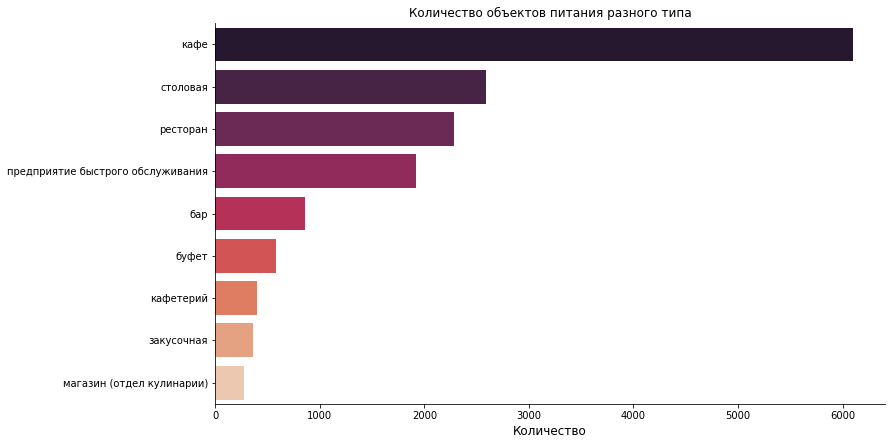

In [28]:
rest_by_type = df.groupby('object_type').agg(count=('id','count')).reset_index().sort_values('count', ascending=False)

plt.figure(figsize=(12, 7))
ax = sns.barplot(x='count', y='object_type', data=rest_by_type, palette="rocket", orient='h')
ax.set_title('Количество объектов питания разного типа')
ax.set_xlabel('Количество', fontsize = 12) 
ax.set_ylabel('') 

# for i, v in enumerate(rest_by_type['count'].values):
#     plt.text(i - .3, v + 50, str(v), color='black', fontsize = 10)
#     plt.text(i - .3, v - 250, '{:.2%}'.format(v / rest_by_type['count'].sum()), color='white', fontsize = 10, fontweight ='bold')

sns.despine()
plt.show()

- Почти 40% объектов нашей базы относятся к типу "кафе"
- Следующие по численности столовые (17%), рестораны (15%) и предприятия быстрого обслуживания (12.5%)
- Значительно меньше баров (5.6%), буфетов (3.8%), кафетериев (2.6%), закусочных (2.3%) и кулинарий (1.8%)

#### 2.2. Cоотношение сетевых и несетевых заведений

,chain,count
0,False,12398
1,True,2968


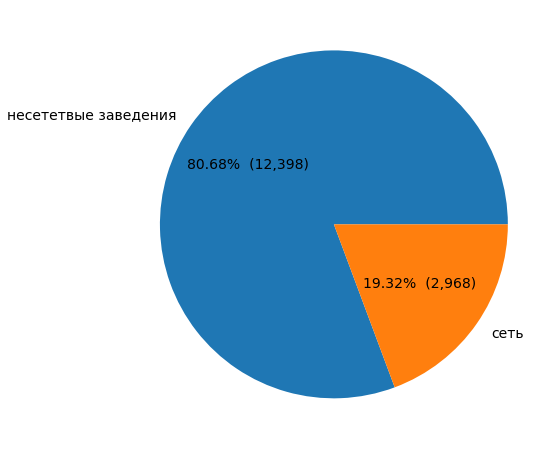

In [12]:
rest_by_chain = df.groupby('chain').agg(count=('id','count')).reset_index()
display(rest_by_chain)

plt.figure(figsize=(8, 8))
plt.pie(rest_by_chain['count'], labels=rest_by_chain['chain'].map({True: 'сеть', False: 'несететвые заведения'}), 
        autopct=lambda p : '{:.2f}%  ({:,.0f})'.format(p,p * sum(rest_by_chain['count'])/100), textprops={'fontsize': 14})
plt.show()

- Более 3/4 заведений являются несетевыми
- Около 19% объектов базы относятся к сетевым

#### 2.3. Виды сетевых объектов

In [13]:
rest_chain_gr = df[df['chain']].groupby('object_type').agg(count=('id','count')).reset_index()

# Добавим в таблицу информацию об общем количестве заведений каждого типа:
rest_chain_gr = rest_chain_gr.merge(rest_by_type, how='left', left_on='object_type', right_on='object_type')
rest_chain_gr.columns = ['object_type', 'chain_count', 'total_count']

# Посчитаем долю сетевых заведений каждого типа:
rest_chain_gr['chain_prc'] = round((rest_chain_gr['chain_count'] / rest_chain_gr['total_count']) * 100, 2)
rest_chain_gr.sort_values('total_count', ascending=False, inplace=True)

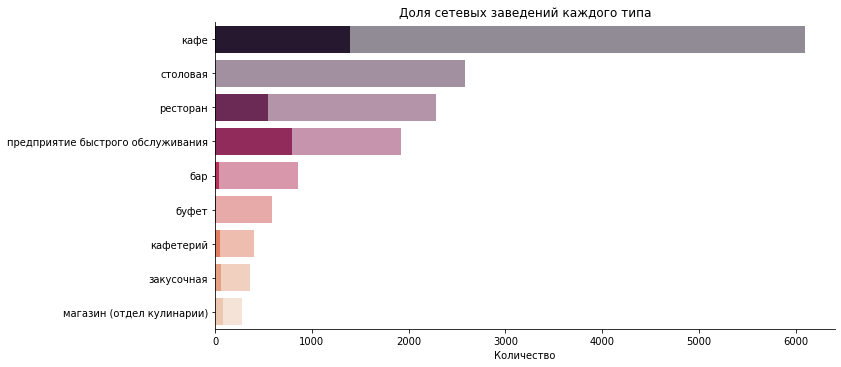

,object_type,chain_count,total_count,chain_prc
3,кафе,1396,6099,22.89
6,предприятие быстрого обслуживания,791,1923,41.13
7,ресторан,544,2285,23.81
5,магазин (отдел кулинарии),78,273,28.57
2,закусочная,56,360,15.56
4,кафетерий,52,398,13.07
0,бар,37,856,4.32
1,буфет,11,585,1.88
8,столовая,3,2587,0.12


In [14]:
g = sns.catplot(data=rest_chain_gr, kind="bar", x="chain_count", y="object_type", palette="rocket", alpha=1,  height=5, aspect=12/5, orient='h')
ax = sns.barplot(x='total_count', y='object_type', data=rest_chain_gr, palette="rocket", alpha=.5,  orient='h')
g.set_axis_labels("Количество", "")
plt.title("Доля сетевых заведений каждого типа")
plt.show()

display(rest_chain_gr.sort_values('chain_count', ascending=False))

- Самая большая доля сетевых объектов приходится на предприятия быстрого обслуживания - 41% от общего числа заведений этого типа
- Далее по содержанию сетевых заведений в общем количестве объектов данного типа следуют отделы кулинарии (~29%), рестораны (24%) и кафе (23%)
- При этом, по абсолютному количеству среди сетей лидируют кафе (1396 точек)

#### 2.4. Сетевые заведения общественного питания

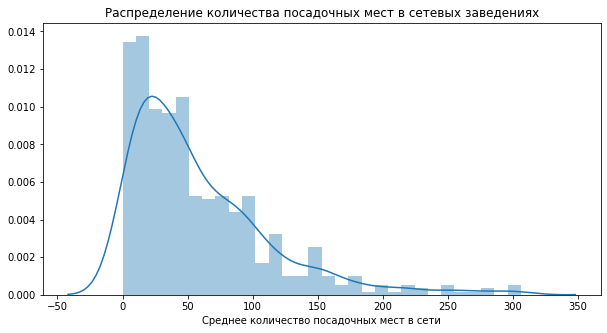

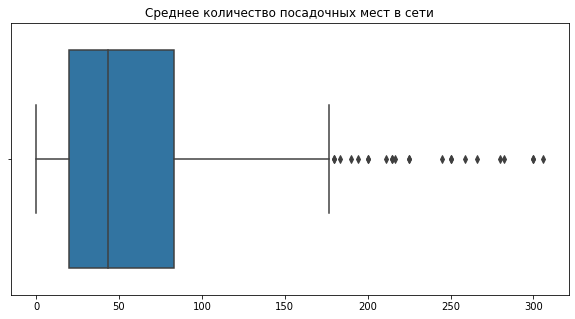

In [15]:
rest_chain = df[df['chain']].groupby(['object_name']).agg(count=('id', 'count'), number_mean=('number','mean'))
rest_chain.sort_values('count', ascending=False, inplace=True)
#display(rest_chain.head())

plt.figure(figsize=(10, 5))
plt.title('Распределение количества посадочных мест в сетевых заведениях')
sns.distplot(rest_chain['number_mean'], bins=30) 
plt.xlabel('Среднее количество посадочных мест в сети')
plt.show()

plt.figure(figsize=(10, 5))
plt.title('Среднее количество посадочных мест в сети')
sns.boxplot(x="number_mean", data=rest_chain)
plt.xlabel('')
plt.show()

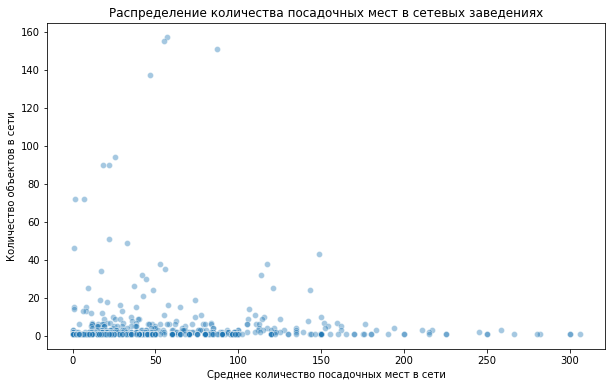

In [16]:
plt.figure(figsize=(10, 6))
#plt.ylim(0,5) # Можно посмотреть поближе в левый нижний угол
plt.title('Распределение количества посадочных мест в сетевых заведениях')
sns.scatterplot(x="number_mean", y="count",
                palette="ch:r=-.2,d=.3_r",
                alpha = 0.4,
                data=rest_chain)
plt.xlabel('Среднее количество посадочных мест в сети')
plt.ylabel('Количество объектов в сети')
plt.show()

- В нашей базе оказалось множество "сетей" состоящих из одного объекта. Разброс количества посадочных мест у них довольно большой. Однако, чаще всего мест немного.

Посмотрим поближе на сети с количеством объектов более 2-х.

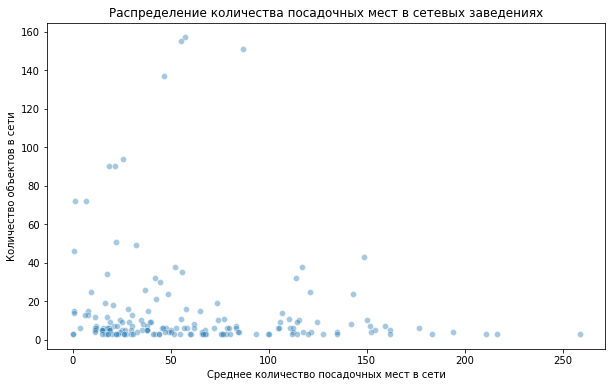

In [17]:
plt.figure(figsize=(10, 6))
#plt.ylim(0,5) # Можно посмотреть поближе в левый нижний угол
plt.title('Распределение количества посадочных мест в сетевых заведениях')
sns.scatterplot(x="number_mean", y="count",
                palette="ch:r=-.2,d=.3_r",
                alpha = 0.4,
                data=rest_chain[rest_chain['count'] > 2])
plt.xlabel('Среднее количество посадочных мест в сети')
plt.ylabel('Количество объектов в сети')
plt.show()

- Картина та же: основная масса сетей сконцентрирована в нижнем левом углу - небольшое количество объектов со средним количеством посадочных мест.
- Крупные сети, во-первых, редко встречаются, и во-вторых, редко имеют более 30-ти посадочных мест.

#### 2.5. Посадочные места в заведениях разного типа

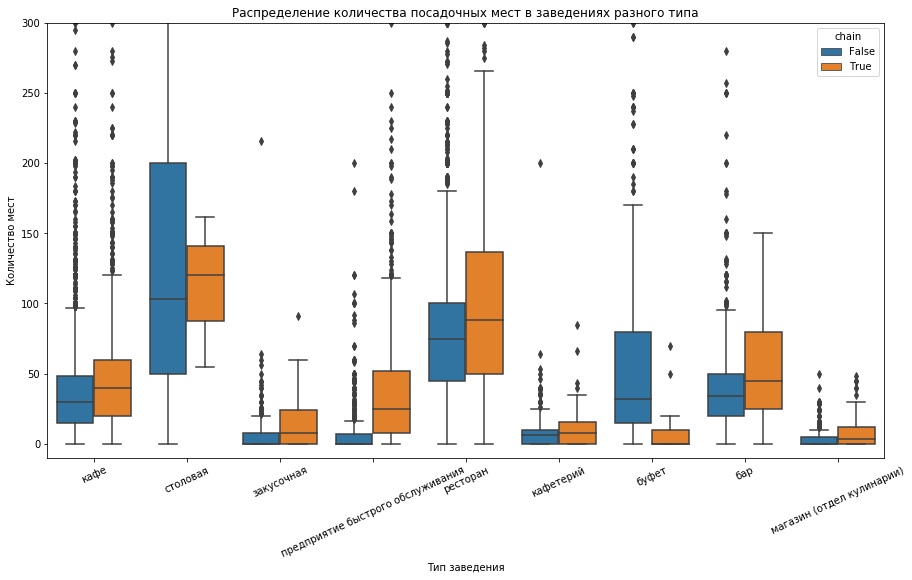

count  number_median
object_type                       chain                      
бар                               False    819           34.0
                                  True      37           45.0
буфет                             False    574           32.0
                                  True      11            0.0
закусочная                        False    304            0.0
                                  True      56            8.0
кафе                              False   4703           30.0
                                  True    1396           40.0
кафетерий                         True      52            8.0
                                  False    346            6.0
магазин (отдел кулинарии)         False    195            0.0
                                  True      78            3.5
предприятие быстрого обслуживания False   1132            0.0
                                  True     791           25.0
ресторан                          False   1741           75.0
                                  True     544           88.5
столовая                          False   2584          103.0
                                  True       3          120.0

In [18]:
plt.figure(figsize=(15, 8))
plt.ylim(-10,300)
plt.title('Распределение количества посадочных мест в заведениях разного типа')
sns.boxplot(x="object_type", y="number", hue="chain", data=df) 
plt.xlabel('Тип заведения')
plt.ylabel('Количество мест') 
plt.xticks(rotation=25)
plt.show()

display(df
        .groupby(['object_type', 'chain'])
        .agg(count=('id', 'count'), number_median=('number', 'median')) # Исп. медиану для оценки ср. числа посадочных мест
        .sort_values('object_type')
       )

Для оценки среднего значения посадочных мест будем использовать медиану, т.к. распределение этих значений отличается от нормального.
- Среднее значение посадочных мест в сетевых заведениях выше, чем в несетевых для всех типов объектов общественного питания.

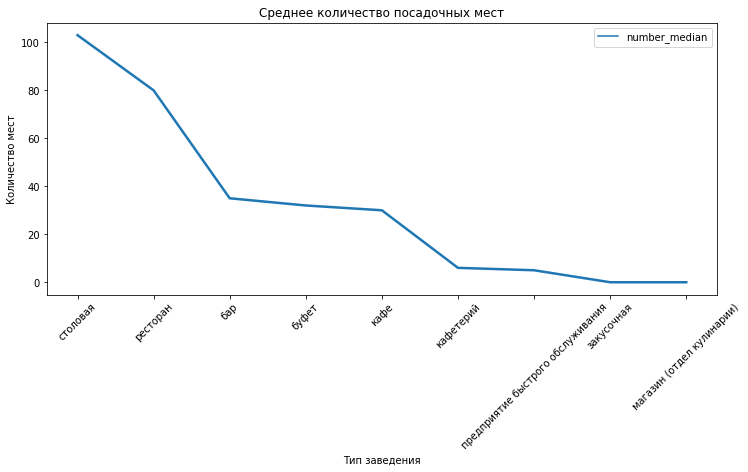

,number_median
object_type,
столовая,103
ресторан,80
бар,35
буфет,32
кафе,30
кафетерий,6
предприятие быстрого обслуживания,5
закусочная,0
магазин (отдел кулинарии),0


In [19]:
rest_number_median = (df
                      .groupby(['object_type'])
                      .agg(number_median=('number', 'median'))
                      .sort_values('number_median', ascending=False)
                     )
plt.figure(figsize=(12, 5))
plt.title('Среднее количество посадочных мест')
sns.lineplot(data=rest_number_median, palette="tab10", style="event", linewidth=2.5, sort=False)
plt.xlabel('Тип заведения')
plt.ylabel('Количество мест') 
plt.xticks(rotation=45)
plt.show()

display(rest_number_median)

- Самое большое количество посадочных мест в среднем предоставляют столовые (103) и рестораны (80)
- Далее по числу мест следуют бары (35), буфеты (32) и кафе (30)
- В среднем мало мест предоставляют кафетерии (6) и предприятия быстрого обслуживания (5)
- В закусочных и магазинах посадочных мест в среднем нет

In [21]:
fig = px.box(df, x='object_type', y='number', color='chain', title='Распределение количества посадочных мест в сетевых заведениях')
fig.update_xaxes(title='Тип заведения')
fig.update_yaxes(title='Количество мест')
fig.show()

#### 2.6. Топ-10 улиц по количеству объектов общественного питания

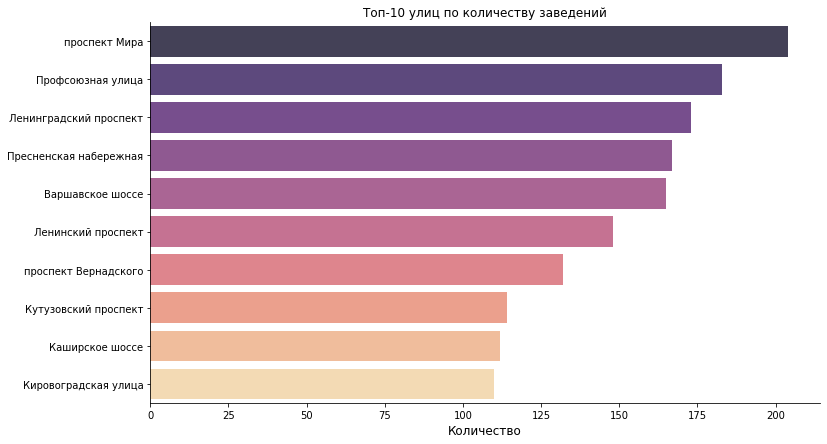

,street,count
0,проспект Мира,204
1,Профсоюзная улица,183
2,Ленинградский проспект,173
3,Пресненская набережная,167
4,Варшавское шоссе,165
5,Ленинский проспект,148
6,проспект Вернадского,132
7,Кутузовский проспект,114
8,Каширское шоссе,112
9,Кировоградская улица,110


In [24]:
rest_by_street = df.groupby('street').agg(count=('id','count')).sort_values('count', ascending=False).reset_index()
rest_by_street_top10 = rest_by_street.head(10)

plt.figure(figsize=(12, 7))
ax = sns.barplot(x='count', y='street', data=rest_by_street_top10, palette="magma", alpha=.8, orient='h')
ax.set_title('Топ-10 улиц по количеству заведений')
ax.set_xlabel('Количество', fontsize = 12) 
ax.set_ylabel('') 
sns.despine()
plt.show()

display(rest_by_street_top10)

Определим районы Москвы, в которых находятся эти улицы.
Для этого воспользуемся внешним источником, например, файлом с данными Мосгаза.

In [37]:
# файл с данными Мосгаза: 
#districts = pd.read_csv('http://hubofdata.ru/storage/f/2013-10-22T09%3A25%3A27.793Z/mosgaz-streets.csv')
districts = pd.read_csv('08_mosgaz-streets.csv')
display(districts.head())

,streetname,areaid,okrug,area
0,Выставочный переулок,17,ЦАО,Пресненский район
1,улица Гашека,17,ЦАО,Пресненский район
2,Большая Никитская улица,17,ЦАО,Пресненский район
3,Глубокий переулок,17,ЦАО,Пресненский район
4,Большой Гнездниковский переулок,17,ЦАО,Пресненский район


In [38]:
# Добавим в отчёт информацию об округе и районе:
rest_by_street = rest_by_street.merge(districts, how='left', left_on='street', right_on='streetname')
rest_by_street = rest_by_street.drop(['streetname', 'areaid'], axis=1)

rest_by_street_top10 = rest_by_street_top10.merge(districts, how='left', left_on='street', right_on='streetname')
rest_by_street_top10 = rest_by_street_top10.drop(['streetname', 'areaid'], axis=1)

In [39]:
display(rest_by_street_top10)

,street,count,okrug,area
0,проспект Мира,204,СВАО,Алексеевский район
1,проспект Мира,204,СВАО,Ярославский Район
2,проспект Мира,204,СВАО,Район Марьина роща
3,проспект Мира,204,СВАО,Останкинский район
4,проспект Мира,204,СВАО,Район Ростокино
5,проспект Мира,204,СВАО,Район Свиблово
6,проспект Мира,204,ЦАО,Мещанский район
7,Профсоюзная улица,183,ЮЗАО,Академический район
8,Профсоюзная улица,183,ЮЗАО,Район Черемушки
9,Профсоюзная улица,183,ЮЗАО,Район Ясенево


- В Топ-10 попали самые длинные улицы Москвы, проходящие сразу через несколько районов, а порой и округов. Не удивительно, что в сумме на этих улицах больше всего заведений общественного питания.

In [40]:
# Посмотрим, через какие округа проходят самые богатые на общепит улицы:
okrug_top10 = pd.DataFrame(rest_by_street_top10.groupby('okrug')['street'].nunique().reset_index()) 

# Все возможные округа:
okrug_total = pd.DataFrame(districts.groupby('okrug')['streetname'].count().reset_index())

# Все районы по округам:
district_total = pd.DataFrame(districts.groupby(['okrug', 'area'])['streetname'].count().reset_index())
#display(okrug_top10)
#display(okrug_total)

# Соберём вместе для наглядности:
rep_okrug_top10 = okrug_top10.merge(okrug_total, how='right', left_on='okrug', right_on='okrug')
rep_okrug_top10 = rep_okrug_top10.drop(['streetname'], axis=1)
rep_okrug_top10['street'] = rep_okrug_top10['street'].fillna(0).astype('int32')
rep_okrug_top10.sort_values('street', ascending=False, inplace=True)

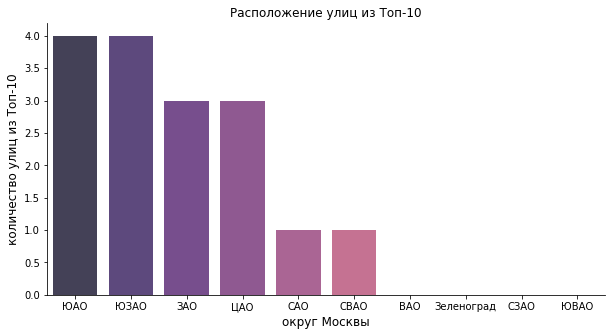

,okrug,street
4,ЮАО,4
5,ЮЗАО,4
0,ЗАО,3
3,ЦАО,3
1,САО,1
2,СВАО,1
6,ВАО,0
7,Зеленоград,0
8,СЗАО,0
9,ЮВАО,0


In [41]:
plt.figure(figsize=(10, 5))
ax = sns.barplot(x='okrug', y='street', data=rep_okrug_top10, palette="magma", alpha=.8)
ax.set_title('Расположение улиц из Топ-10')
ax.set_xlabel('округ Москвы', fontsize = 12) 
ax.set_ylabel('количество улиц из Топ-10', fontsize = 12) 
sns.despine()
plt.show()

display(rep_okrug_top10)

- Самые богатые на общепит улицы находятся преимущественно на юге и западе Москвы, некоторые дотягиваются и до центра.

#### 2.7. Улицы с одним объектом общественного питания

In [45]:
one_rest_streets = rest_by_street[rest_by_street['count'] == 1]
one_rest_streets.sort_values(['count','street'], ascending=['True', 'False'], inplace=True)

display(one_rest_streets.sample(5))

,street,count,okrug,area
2158,Пулковская улица,1,САО,Головинский район
1877,улица Жебрунова,1,ВАО,Район Сокольники
2289,Большой Казённый переулок,1,ЦАО,Басманный район
2193,Сивашская улица,1,ЮЗАО,Район Зюзино
2011,7-я улица Лазенки,1,ЗАО,Район Ново-Переделкино


In [46]:
# Посмотрим, через какие округа проходят самые обделённые общепитом улицы:
okrug_one_rest = pd.DataFrame(one_rest_streets.groupby('okrug')['street'].nunique().reset_index()) 

# Добавим для наглядности остальные округа:
rep_okrug_one_rest = okrug_one_rest.merge(okrug_total, how='right', left_on='okrug', right_on='okrug')
rep_okrug_one_rest = rep_okrug_one_rest.drop(['streetname'], axis=1)
#okrug_one_rest['street'] = okrug_one_rest['street'].fillna(0).astype('int32')
rep_okrug_one_rest.sort_values('street', ascending=False, inplace=True)

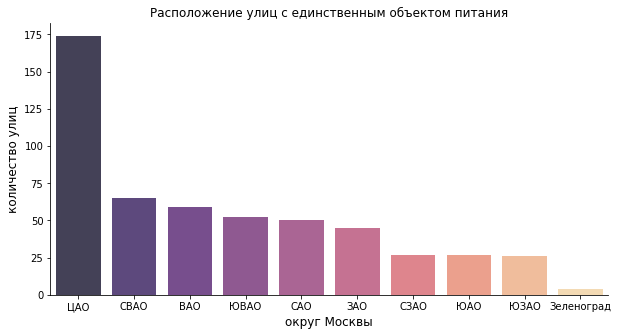

,okrug,street,prc
6,ЦАО,174,32.89
4,СВАО,65,12.29
0,ВАО,59,11.15
8,ЮВАО,52,9.83
3,САО,50,9.45
1,ЗАО,45,8.51
5,СЗАО,27,5.10
7,ЮАО,27,5.10
9,ЮЗАО,26,4.91
2,Зеленоград,4,0.76


In [47]:
plt.figure(figsize=(10, 5))
ax = sns.barplot(x='okrug', y='street', data=rep_okrug_one_rest, palette="magma", alpha=.8)
ax.set_title('Расположение улиц с единственным объектом питания')
ax.set_xlabel('округ Москвы', fontsize = 12) 
ax.set_ylabel('количество улиц', fontsize = 12) 
sns.despine()
plt.show()

rep_okrug_one_rest['prc'] = round((rep_okrug_one_rest['street'] / rep_okrug_one_rest['street'].sum()) * 100, 2)
rep_okrug_one_rest

In [48]:
# Районы, через которые проходят улицы с единственным объектом:
district_one_rest = pd.DataFrame(one_rest_streets.groupby('area')['street'].nunique().reset_index()) 
district_one_rest.sort_values('street', ascending=False, inplace=True)

# Добавим для наглядности округа:
rep_district_one_rest = district_one_rest.merge(district_total, how='left', left_on='area', right_on='area')
rep_district_one_rest = rep_district_one_rest.drop(['streetname'], axis=1)

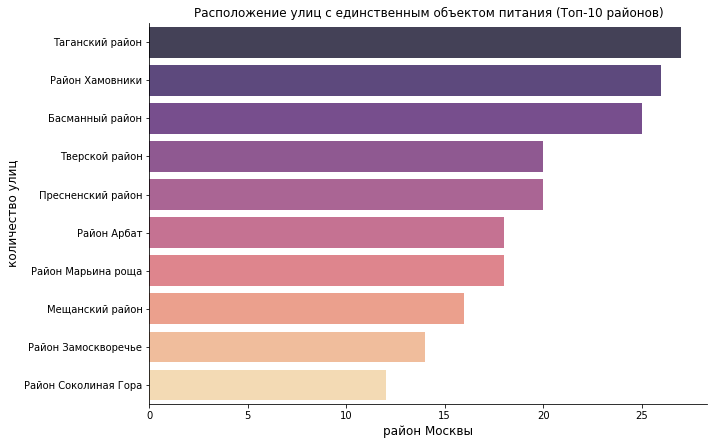

,area,street,okrug
0,Таганский район,27,ЦАО
1,Район Хамовники,26,ЦАО
2,Басманный район,25,ЦАО
3,Тверской район,20,ЦАО
4,Пресненский район,20,ЦАО
5,Район Арбат,18,ЦАО
6,Район Марьина роща,18,СВАО
7,Мещанский район,16,ЦАО
8,Район Замоскворечье,14,ЦАО
9,Район Соколиная Гора,12,ВАО


Количество улиц с единственным объектом общественного питания: 596


In [49]:
plt.figure(figsize=(10, 7))
ax = sns.barplot(x='street', y='area', data=rep_district_one_rest.head(10), palette="magma", alpha=.8, orient='h')
ax.set_title('Расположение улиц с единственным объектом питания (Топ-10 районов)')
ax.set_xlabel('район Москвы', fontsize = 12) 
ax.set_ylabel('количество улиц', fontsize = 12) 
sns.despine()
plt.show()

display(rep_district_one_rest.head(10))
print('\033[1m'+'Количество улиц с единственным объектом общественного питания:', one_rest_streets['count'].sum())

- Всего в базе 596 улиц с единственным объектом питания
- Самое большое количество улиц с одним заведением находится в центральных районах города: Таганском, Хамовниках, Басманном, Тверском, Пресненском и др.
- Кроме того, почти треть всех улиц с одним объектом находится в центре Москвы
- Следом идут северные и восточные направления (СВАО, ВАО, ЮВАО, САО)

#### 2.8. Распределение количества посадочных мест для улиц из Топ-10

In [50]:
top10_rest = df[df['street'].isin(rest_by_street_top10['street'].unique())]
#top10_rest # 1508 записей

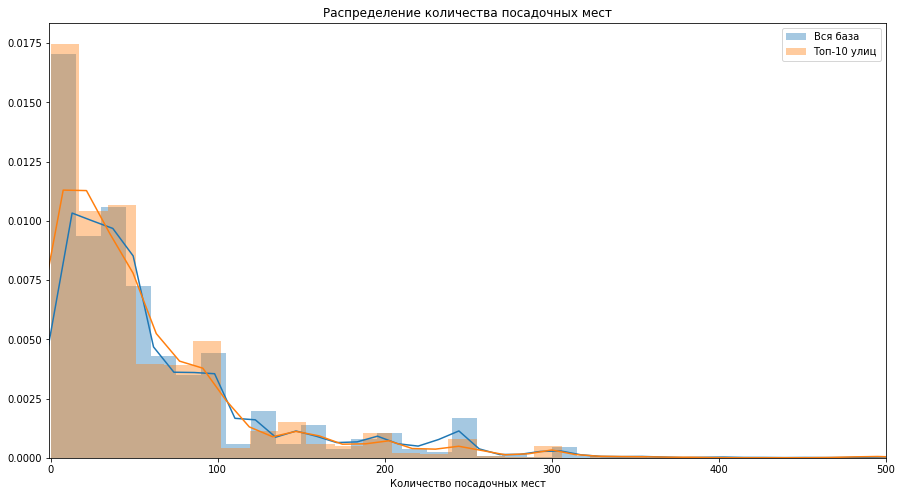

In [51]:
plt.figure(figsize=(15, 8))
plt.xlim(-1,500)
plt.title('Распределение количества посадочных мест')
sns.distplot(df[~df['street'].isin(rest_by_street_top10['street'].unique())]['number'], bins=100, label='Вся база') 
sns.distplot(top10_rest['number'], bins=100, label='Топ-10 улиц') 
plt.xlabel('Количество посадочных мест')
plt.legend()
plt.show()

- Распределения количества посадочных мест на улицах из Топ-10 и по всей остальной базе практически совпадают

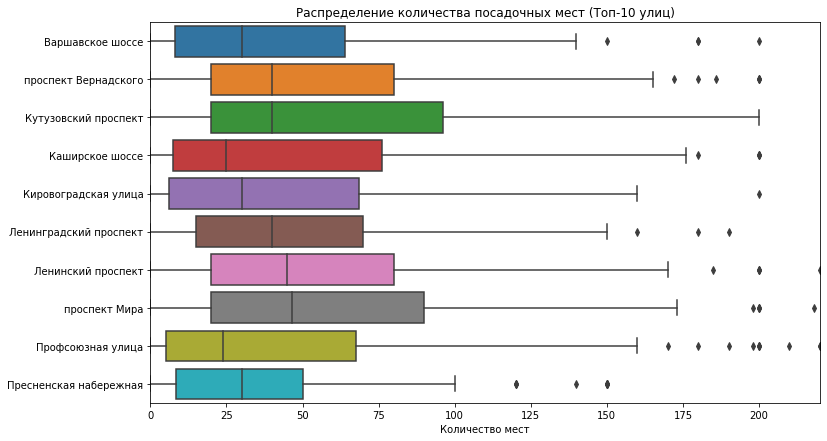

In [52]:
plt.figure(figsize=(12, 7))
plt.xlim(0,220)
plt.title('Распределение количества посадочных мест (Топ-10 улиц)')
#sns.scatterplot(x="street", y="number", data=top10_rest) 
sns.boxplot(x="number", y="street", data=top10_rest, orient='h') 
plt.xlabel('Количество мест')
plt.ylabel('') 
plt.show()

- Тенденции по Топ-10 совпадают со всей базой в целом: большинство заведений предоставляют не более 50 посадочных мест, более 100 мест встречаются крайне редко.

Проверим гипотезу о равенстве среднего количества посадочных мест на улицах из Топ-10 и остальных улицах базы, т.е. о равенстве двух независимых выборок.
Т.к. распределения средних значений отличаются от нормального и они не зависят между собой, воспользуемся критерием Манна-Уитни:

In [56]:
top10_number = top10_rest['number'].values

df_number = df[~df['street'].isin(rest_by_street_top10['street'].unique())]['number'].values

alpha = .05 # критический уровень статистической значимости

results = st.mannwhitneyu(top10_number, df_number)

print('\033[1mНулевая гипотеза H0: между выборками нет разницы\033[0m')
print('p-значение: ', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

Нулевая гипотеза H0: между выборками нет разницы
p-значение:  0.056708787197104
Не получилось отвергнуть нулевую гипотезу


- Итак, у нас нет оснований считать, что среднее количество посадочных мест в заведениях общепита на улицах из Топ-10 отличается от среднего количества мест по остальной базе

### [4. Общий вывод](#plan) <a id="st4"></a> 

**Виды объектов общественного питания:**
- **Кафе** - самое распространённое заведение общественного питания - около 40% всей базы относятся к данному типу
- Следующие по численности столовые (17%), рестораны (15%) и предприятия быстрого обслуживания (12.5%)
- Значительно меньше баров (5.6%), буфетов (3.8%), кафетериев (2.6%), закусочных (2.3%) и кулинарий (1.8%)

**Сетевые заведения:**
- Менее 1/4 (19%) заведений являются сетевыми
- Самая большая доля сетевых объектов приходится на предприятия быстрого обслуживания - 41% от общего числа заведений этого типа
- Далее по содержанию сетевых заведений в общем количестве объектов данного типа следуют отделы кулинарии (~29%), рестораны (24%) и кафе (23%)
- При этом, по абсолютному количеству среди сетей лидируют кафе

**Посадочные места:**
- Самое большое количество посадочных мест в среднем предоставляют столовые (103) и рестораны (80)
- Далее по числу мест следуют бары (35), буфеты (32) и кафе (30)
- В среднем мало мест предоставляют кафетерии (6) и предприятия быстрого обслуживания (5)
- В закусочных и магазинах посадочных мест чаще всего нет
- Среднее значение посадочных мест в сетевых заведениях выше, чем в несетевых для всех типов объектов общественного питания
- Основная масса сетей состоит из небольшого количества объектов со средним количеством посадочных мест (20-30)
- Крупные сети, во-первых, редко встречаются, и во-вторых, редко имеют более 30-ти посадочных мест

**Расположение объектов общественного питания:**
- Самые богатые на общепит улицы проходят сразу через несколько районов, а порой и округов Москвы, и располагаются преимущественно на юге и западе города
- В базе оказалось 596 улиц с единственным объектом питания
- Самое большое количество улиц с одним заведением находится в центральных районах города: Таганском, Хамовниках, Басманном, Тверском, Пресненском и др.
- Кроме того, почти треть всех улиц с единственным объектом общественного питания находится в центре Москвы. Далее по "непопулярности" идут северные и восточные направления (СВАО, ВАО, ЮВАО, САО) города

**Посадочные места в заведениях на "популярных" улицах:**
- Распределения количества посадочных мест на улицах из Топ-10 и по всей остальной базе практически совпадают
- Тенденции по Топ-10 совпадают со всей базой в целом: большинство заведений предоставляют не более 50 посадочных мест, более 100 мест встречаются крайне редко
- у нас нет оснований считать, что среднее количество посадочных мест в заведениях общепита на улицах из Топ-10 отличается от среднего количества мест по остальной базе

В ходе исследования мы подтвердили, что **небольшое кафе** - это довольно перспективный вариант заведения общественного питания. Также нам удалось установить оптимальное количество посадочных мест - **30-40** - и наиболее популярные с точки зрения общепита районы Москвы - **ЮАО, ЮЗАО, ЗАО**. Практика конкурентов показывает, что такой формат заведений масштабируется чаще, чем, например, предприятия быстрого обслуживания или рестораны, т.е. доказана возможность развития сети.

### [5. Презентация](#plan) <a id="st5"></a> 

Презентация: https://yadi.sk/i/oEQ_otkc0KgzKw